# 신용카드 사용자 연체 예측 AI 경진대회
이 노트북은 Dacon 신용카드 사용자 연체 예측 AI 경진대회의 베이스라인 코드입니다.

## 분석 순서
1. 데이터 로드 및 확인
2. 데이터 전처리 (결측치, 인코딩, 파생변수)
3. 데이터 탐색 (EDA)
4. 모델링 (RandomForest Baseline)
5. 제출 파일 생성

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 한글 폰트 설정 (Windows: Malgun Gothic)
plt.rc('font', family='Malgun Gothic')
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## 1. 데이터 로드

In [43]:
try:
    train = pd.read_csv('../data/train.csv')
    test = pd.read_csv('../data/test.csv')
    submission = pd.read_csv('../data/sample_submission.csv')
    print("데이터 로드 완료")
    print(f"원본 Train 컬럼 수: {len(train.columns)}")
    print(f"원본 Test 컬럼 수: {len(test.columns)}")
except FileNotFoundError:
    print("데이터 파일이 ../data/ 폴더에 있는지 확인해주세요.")

데이터 로드 완료
원본 Train 컬럼 수: 20
원본 Test 컬럼 수: 19


## 2. 데이터 전처리 및 인코딩
- 결측치 처리 (occyp_type)
- 파생변수 생성 (age, worked_years)
- 범주형 변수 인코딩 (Label Encoding)
- 불필요한 컬럼 삭제

In [44]:
def preprocess_data(df):
    # 결측치 처리: occyp_type (직업 유형)의 결측치를 'None'으로 대체
    df['occyp_type'] = df['occyp_type'].fillna('None')
    
    # DAYS_BIRTH -> age (나이)
    df['age'] = abs(df['DAYS_BIRTH']) // 365
    
    # DAYS_EMPLOYED -> worked_years (근무 연수)
    # 양수(365243)는 무직을 의미하므로 0으로 처리
    df['worked_years'] = df['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else abs(x) // 365)
    
    # begin_month -> 발행된지 몇 달 되었는지 (발행 개월)
    df['begin_month'] = abs(df['begin_month'])
    
    # 불필요한 컬럼 삭제
    df = df.drop(['index', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1, errors='ignore')
    
    return df

In [45]:
if 'train' in locals():
    train_df = preprocess_data(train.copy())
    test_df = preprocess_data(test.copy())
    
    # 인코딩 전 컬럼 수 확인
    print(f"전처리 후 (인코딩 전) Train 컬럼 수: {train_df.shape[1]}")
    
    # Label Encoding
    from sklearn.preprocessing import LabelEncoder
    
    # 범주형 컬럼 리스트 추출
    cat_cols = train_df.select_dtypes(include='object').columns
    print(f"인코딩 대상 범주형 컬럼: {list(cat_cols)}")
    
    for col in cat_cols:
        le = LabelEncoder()
        combined = pd.concat([train_df[col], test_df[col]], axis=0)
        le.fit(combined)
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
    
    print("\n--- 인코딩 완료 ---")
    print(f"최종 Train 데이터 셋 Shape: {train_df.shape}")
    print(f"최종 Test 데이터 셋 Shape: {test_df.shape}")
    print(f"학습에 사용될 최종 컬럼 수: {train_df.shape[1] - 1} (target 제외)")
    print(f"최종 컬럼 목록: {list(train_df.columns)}")

전처리 후 (인코딩 전) Train 컬럼 수: 18
인코딩 대상 범주형 컬럼: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

--- 인코딩 완료 ---
최종 Train 데이터 셋 Shape: (26457, 18)
최종 Test 데이터 셋 Shape: (10000, 17)
학습에 사용될 최종 컬럼 수: 17 (target 제외)
최종 컬럼 목록: ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'credit', 'age', 'worked_years']


## 3. 데이터 탐색 (EDA)
직업 유형(occyp_type)의 분포를 막대그래프로 확인합니다.

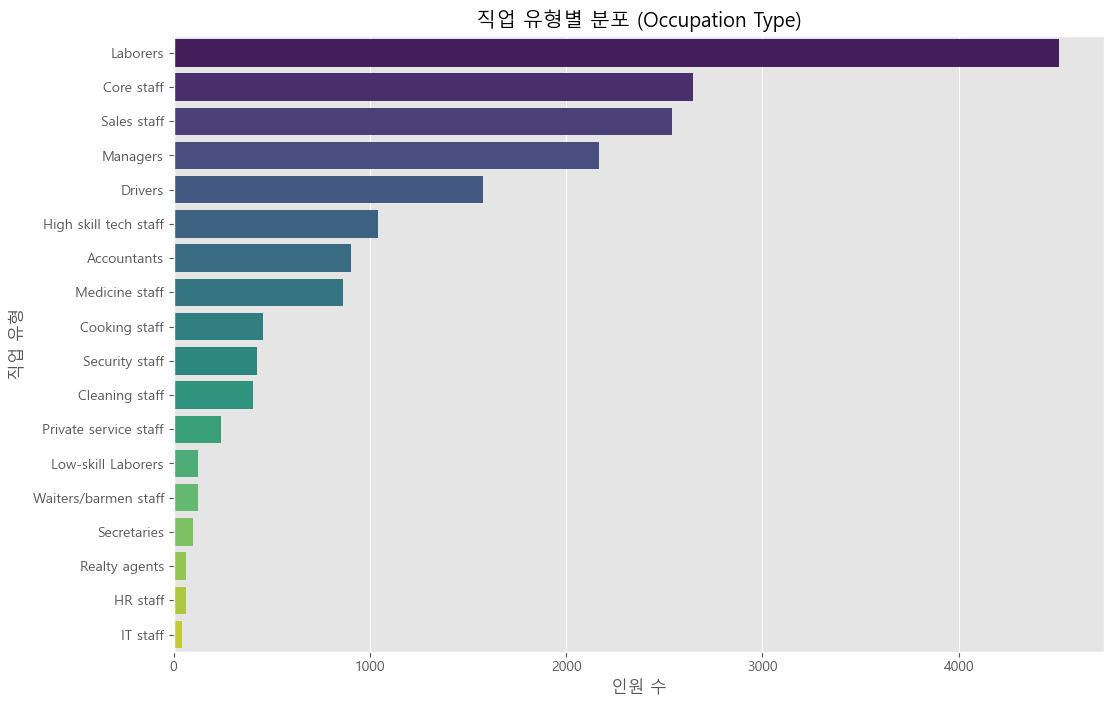

In [46]:
if 'train' in locals():
    plt.figure(figsize=(12, 8))
    sns.countplot(data=train, y='occyp_type', palette='viridis', 
                  order=train['occyp_type'].value_counts().index)
    plt.title('직업 유형별 분포 (Occupation Type)')
    plt.xlabel('인원 수')
    plt.ylabel('직업 유형')
    plt.show()

## 4. 모델링 (RandomForest Baseline)
중복 데이터를 방지하기 위해 Stratified K-Fold를 사용합니다.

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

if 'train_df' in locals():
    X = train_df.drop('credit', axis=1)
    y = train_df['credit']
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rf_models = []
    log_losses = []
    
    for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"--- Fold {i+1} --- ")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_val)
        loss = log_loss(y_val, y_pred_proba)
        
        rf_models.append(model)
        log_losses.append(loss)
        print(f"Log Loss: {loss:.4f}")
        
    print(f"평균 Log Loss: {np.mean(log_losses):.4f}")

--- Fold 1 --- 
Log Loss: 0.9199
--- Fold 2 --- 
Log Loss: 0.9375
--- Fold 3 --- 
Log Loss: 0.9450
--- Fold 4 --- 
Log Loss: 0.9082
--- Fold 5 --- 
Log Loss: 0.9776
평균 Log Loss: 0.9376


### 4.1 결측치 확인
데이터셋에 존재하는 결측치를 확인합니다.

In [48]:
if 'train' in locals():
    print("--- Train Data Missing Values ---")
    print(train.isnull().sum())
    print("\n--- Test Data Missing Values ---")
    print(test.isnull().sum())

--- Train Data Missing Values ---
index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

--- Test Data Missing Values ---
index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64


#### 4.2 피처 엔지니어링(Feature Engineering)

In [49]:
# feature_engineering_with_target.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def feature_engineering(df: pd.DataFrame, target_col: str = 'default_payment_next_month', show_graphs: bool = True) -> pd.DataFrame:
    """
    credit_card_prediction 프로젝트용 피처 엔지니어링 + 타겟 변수(default 여부) 기반 그래프 시각화
    입력: 원본 데이터프레임
    출력: 전처리 및 피처 엔지니어링된 데이터프레임
    """

    df = df.copy()

    # ===== 결측치 처리 =====
    df.fillna({
        'AGE': df['AGE'].median(),
        'LIMIT_BAL': df['LIMIT_BAL'].median(),
        'SEX': df['SEX'].mode()[0],
        'EDUCATION': df['EDUCATION'].mode()[0],
        'MARRIAGE': df['MARRIAGE'].mode()[0]
    }, inplace=True)

    # ===== 파생변수 생성 =====
    if 'BILL_AMT1' in df.columns and 'LIMIT_BAL' in df.columns:
        df['UTILIZATION_RATIO'] = df['BILL_AMT1'] / (df['LIMIT_BAL'] + 1)

    bill_cols = [col for col in df.columns if 'BILL_AMT' in col]
    if bill_cols:
        df['AVG_BILL_AMT'] = df[bill_cols].mean(axis=1)

    pay_cols = [col for col in df.columns if 'PAY_AMT' in col]
    if pay_cols:
        df['AVG_PAY_AMT'] = df[pay_cols].mean(axis=1)

    if 'AVG_BILL_AMT' in df.columns and 'AVG_PAY_AMT' in df.columns:
        df['PAYMENT_RATIO'] = df['AVG_PAY_AMT'] / (df['AVG_BILL_AMT'] + 1)

    # ===== 그래프 시각화 (타겟 변수 기준) =====
    if show_graphs and target_col in df.columns:
        plt.figure(figsize=(15, 4))

        # 1. 성별 vs default 여부
        plt.subplot(1, 3, 1)
        sns.countplot(x='SEX', hue=target_col, data=df, palette='pastel')
        plt.title('SEX vs Default')

        # 2. 교육 수준 vs default 여부
        plt.subplot(1, 3, 2)
        sns.countplot(x='EDUCATION', hue=target_col, data=df, palette='muted')
        plt.title('EDUCATION vs Default')

        # 3. 결혼 여부 vs default 여부
        plt.subplot(1, 3, 3)
        sns.countplot(x='MARRIAGE', hue=target_col, data=df, palette='Set2')
        plt.title('MARRIAGE vs Default')

        plt.tight_layout()
        plt.show()

        # 수치형 변수와 default 여부 관계 (박스플롯)
        plt.figure(figsize=(12, 5))
        sns.boxplot(x=target_col, y='UTILIZATION_RATIO', data=df, palette='coolwarm')
        plt.title('Utilization Ratio vs Default')
        plt.show()

    # ===== 범주형 인코딩 + 수치형 스케일링 =====
    categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
    numeric_features = ['AGE', 'LIMIT_BAL', 'UTILIZATION_RATIO',
                        'AVG_BILL_AMT', 'AVG_PAY_AMT', 'PAYMENT_RATIO']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    df_transformed = preprocessor.fit_transform(df)

    feature_names = (numeric_features +
                     list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))
    df_final = pd.DataFrame(df_transformed.toarray(), columns=feature_names)

    # 타겟 변수도 함께 반환
    df_final[target_col] = df[target_col].values

    return df_final

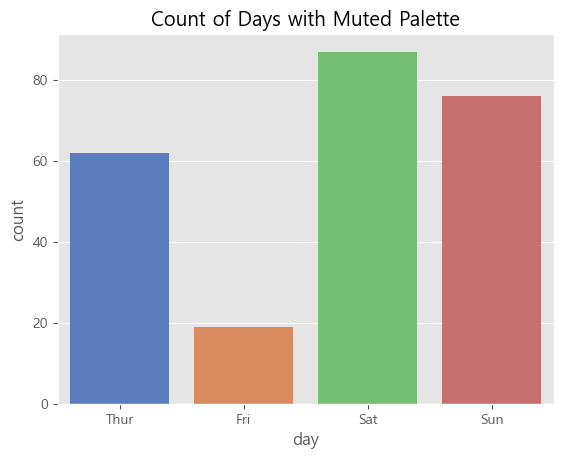

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예시 데이터
tips = sns.load_dataset("tips")

# 기본 countplot
sns.countplot(x="day", data=tips, palette="muted")
plt.title("Count of Days with Muted Palette")
plt.show()

#### 4.3 신용카드 수치화 데이터

MSE: 10.171473008541128
R2 Score: 0.9965585241700424


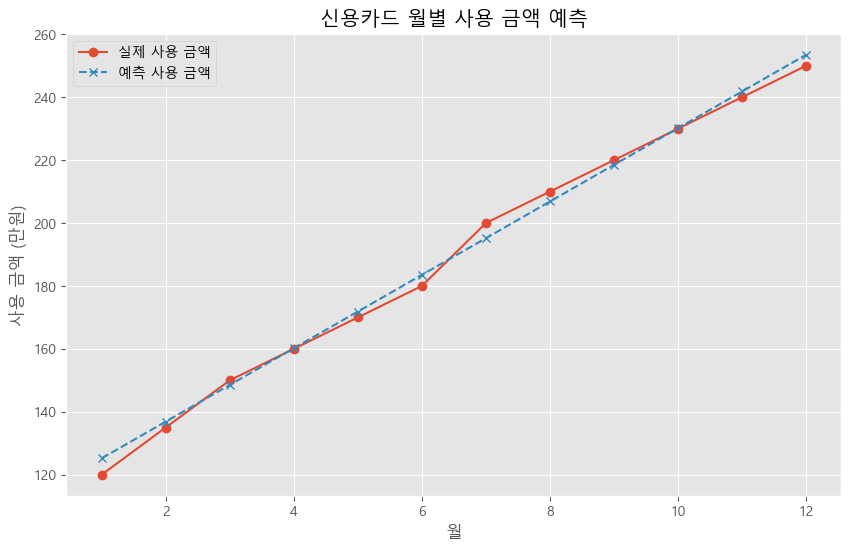

In [51]:
# credit_card_prediction.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. 예시 데이터 생성 (실제 데이터셋이 있다면 불러오기)
# 예: 월별 신용카드 사용 금액 (단위: 만원)
data = {
    "month": np.arange(1, 13),
    "usage": [120, 135, 150, 160, 170, 180, 200, 210, 220, 230, 240, 250]
}
df = pd.DataFrame(data)

# 2. 학습 데이터 준비
X = df[["month"]]   # 독립변수: 월
y = df["usage"]     # 종속변수: 사용 금액

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 4. 예측
y_pred = model.predict(X_test)

# 5. 성능 평가
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# 6. 전체 데이터에 대한 예측값 추가
df["predicted_usage"] = model.predict(X)

# 7. 그래프 시각화
plt.figure(figsize=(10,6))
plt.plot(df["month"], df["usage"], marker="o", label="실제 사용 금액")
plt.plot(df["month"], df["predicted_usage"], marker="x", linestyle="--", label="예측 사용 금액")
plt.title("신용카드 월별 사용 금액 예측")
plt.xlabel("월")
plt.ylabel("사용 금액 (만원)")
plt.legend()
plt.grid(True)
plt.show()

#### 4.4 신용한도(LIMIT_BAL)대비 청구액(BILL_AMT)

In [41]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("credit_card_prediction.csv")

# 2. Utilization Ratio 컬럼 추가
# BILL_AMT1 / LIMIT_BAL
df["Utilization_Ratio"] = df["BILL_AMT1"] / (df["LIMIT_BAL"] + 1)

# 3. 결과 확인
print(df.head())

# 4. 다시 CSV로 저장 (원한다면)
df.to_csv("credit_card_prediction_with_utilization.csv", index=False)
print("새로운 CSV 파일이 저장되었습니다!")

   ID  LIMIT_BAL SEX  EDUCATION  MARRIAGE  AGE  BILL_AMT1  PAY_AMT1  \
0   1      20000   M          2         1   24       3913         0   
1   2     120000   F          1         2   35       2682      1000   
2   3      90000   F          3         2   29       8617      2000   
3   4      50000   M          2         1   40      12000      5000   
4   5     180000   F          1         3   50       1500      1500   

   default_payment_next_month  Utilization_Ratio  
0                           1           0.195640  
1                           0           0.022350  
2                           0           0.095743  
3                           1           0.239995  
4                           0           0.008333  
새로운 CSV 파일이 저장되었습니다!


## 5. 최종 예측 및 제출 파일 생성

In [19]:
if 'rf_models' in locals() and rf_models:
    final_preds = np.zeros((test_df.shape[0], 3))
    
    for model in rf_models:
        final_preds += model.predict_proba(test_df) / len(rf_models)
    
    submission.iloc[:, 1:] = final_preds
    import os
    if not os.path.exists('output'):
        os.makedirs('output')
    submission.to_csv('output/baseline_submission.csv', index=False)
    print("제출 파일 저장 완료: output/baseline_submission.csv")

제출 파일 저장 완료: output/baseline_submission.csv


In [36]:
import pandas as pd

# 예시 데이터 생성
data = {
    "ID": [1, 2, 3, 4, 5],
    "LIMIT_BAL": [20000, 120000, 90000, 50000, 180000],
    "SEX": ["M", "F", "F", "M", "F"],
    "EDUCATION": [2, 1, 3, 2, 1],   # 1=대학, 2=대학원, 3=고등학교
    "MARRIAGE": [1, 2, 2, 1, 3],    # 1=기혼, 2=미혼, 3=기타
    "AGE": [24, 35, 29, 40, 50],
    "BILL_AMT1": [3913, 2682, 8617, 12000, 1500],
    "PAY_AMT1": [0, 1000, 2000, 5000, 1500],
    "default_payment_next_month": [1, 0, 0, 1, 0]  # 1=연체, 0=정상
}

df = pd.DataFrame(data)

# CSV 파일로 저장
df.to_csv("credit_card_prediction.csv", index=False)

print("credit_card_prediction.csv 파일이 생성되었습니다!")

credit_card_prediction.csv 파일이 생성되었습니다!
